<a href="https://colab.research.google.com/github/Tinuanandh/PRODIGY_ML_01/blob/main/House_Price_Regression_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'paris-housing-price-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1440281%2F2382940%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240515%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240515T075750Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5a0221bc94a0dd7710c1d96bb965cd6e6bcf3bb173cdfc1499bb84089039e42ce4d1c7b6f036785a830cb53d034330c5494fe1e9d540f9750964c102368c08c2b1058d73f629b6687bc15518d0f93230c15edcaccd0d17bd6d13c49549db1feac87dd170f6e118c7211730334c4d2ad5a68c287e4b6db3a87b6bfe68af5c06ee7133ced57bf7df4f30f6857011feb2a2fe883d72ccd90f282f1c20ebd6ef6a570f48f7c58609f3e1bb4bb63d7c27dad73af6a864f646aacb7636401ed02512b968a00ec8995a1a59d6d9232fba07a3a85af397390b8dcf61d7a4b7bf7a17f1518a6232bb017a9440493f7a8b409d8cf9642b341f60076557d6977800a7c8e48a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 275823 bytes downloaded
Downloaded and uncompressed: paris-housing-price-prediction
Data source import complete.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/kaggle/input/paris-housing-price-prediction/ParisHousing.csv')
df.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0


## Objectives

* Proceed to explanatory data analysis, data overview & cleasing
* Use seaborn to create visualization through density plots
* Analyze the correlation between all the independent variables that influence the changes in value of our dependant variable, the price
* Use machine learning to split the data and test different models and identify one to predict housing price in Paris.

## Data Exploration

In [4]:
# statistical info
df.describe()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.00000,1.000000e+04
mean,49870.13120,50.358400,0.508700,0.496800,50.276300,50225.486100,5.510100,5.521700,2005.48850,0.499100,0.499900,5033.103900,5028.01060,553.12120,0.503000,4.99460,4.993448e+06
std,28774.37535,28.816696,0.499949,0.500015,28.889171,29006.675799,2.872024,2.856667,9.30809,0.500024,0.500025,2876.729545,2894.33221,262.05017,0.500016,3.17641,2.877424e+06
min,89.00000,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.00000,0.000000,0.000000,0.000000,1.00000,100.00000,0.000000,0.00000,1.031350e+04
25%,25098.50000,25.000000,0.000000,0.000000,25.000000,24693.750000,3.000000,3.000000,1997.00000,0.000000,0.000000,2559.750000,2512.00000,327.75000,0.000000,2.00000,2.516402e+06
50%,50105.50000,50.000000,1.000000,0.000000,50.000000,50693.000000,5.000000,5.000000,2005.50000,0.000000,0.000000,5092.500000,5045.00000,554.00000,1.000000,5.00000,5.016180e+06
75%,74609.75000,75.000000,1.000000,1.000000,76.000000,75683.250000,8.000000,8.000000,2014.00000,1.000000,1.000000,7511.250000,7540.50000,777.25000,1.000000,8.00000,7.469092e+06
max,99999.00000,100.000000,1.000000,1.000000,100.000000,99953.000000,10.000000,10.000000,2021.00000,1.000000,1.000000,10000.000000,10000.00000,1000.00000,1.000000,10.00000,1.000677e+07


In [5]:
# datatype info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       10000 non-null  int64  
 1   numberOfRooms      10000 non-null  int64  
 2   hasYard            10000 non-null  int64  
 3   hasPool            10000 non-null  int64  
 4   floors             10000 non-null  int64  
 5   cityCode           10000 non-null  int64  
 6   cityPartRange      10000 non-null  int64  
 7   numPrevOwners      10000 non-null  int64  
 8   made               10000 non-null  int64  
 9   isNewBuilt         10000 non-null  int64  
 10  hasStormProtector  10000 non-null  int64  
 11  basement           10000 non-null  int64  
 12  attic              10000 non-null  int64  
 13  garage             10000 non-null  int64  
 14  hasStorageRoom     10000 non-null  int64  
 15  hasGuestRoom       10000 non-null  int64  
 16  price              1000

In [6]:
# check for null values
df.isnull().sum()

squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
price                0
dtype: int64

## Data visualization through density plots

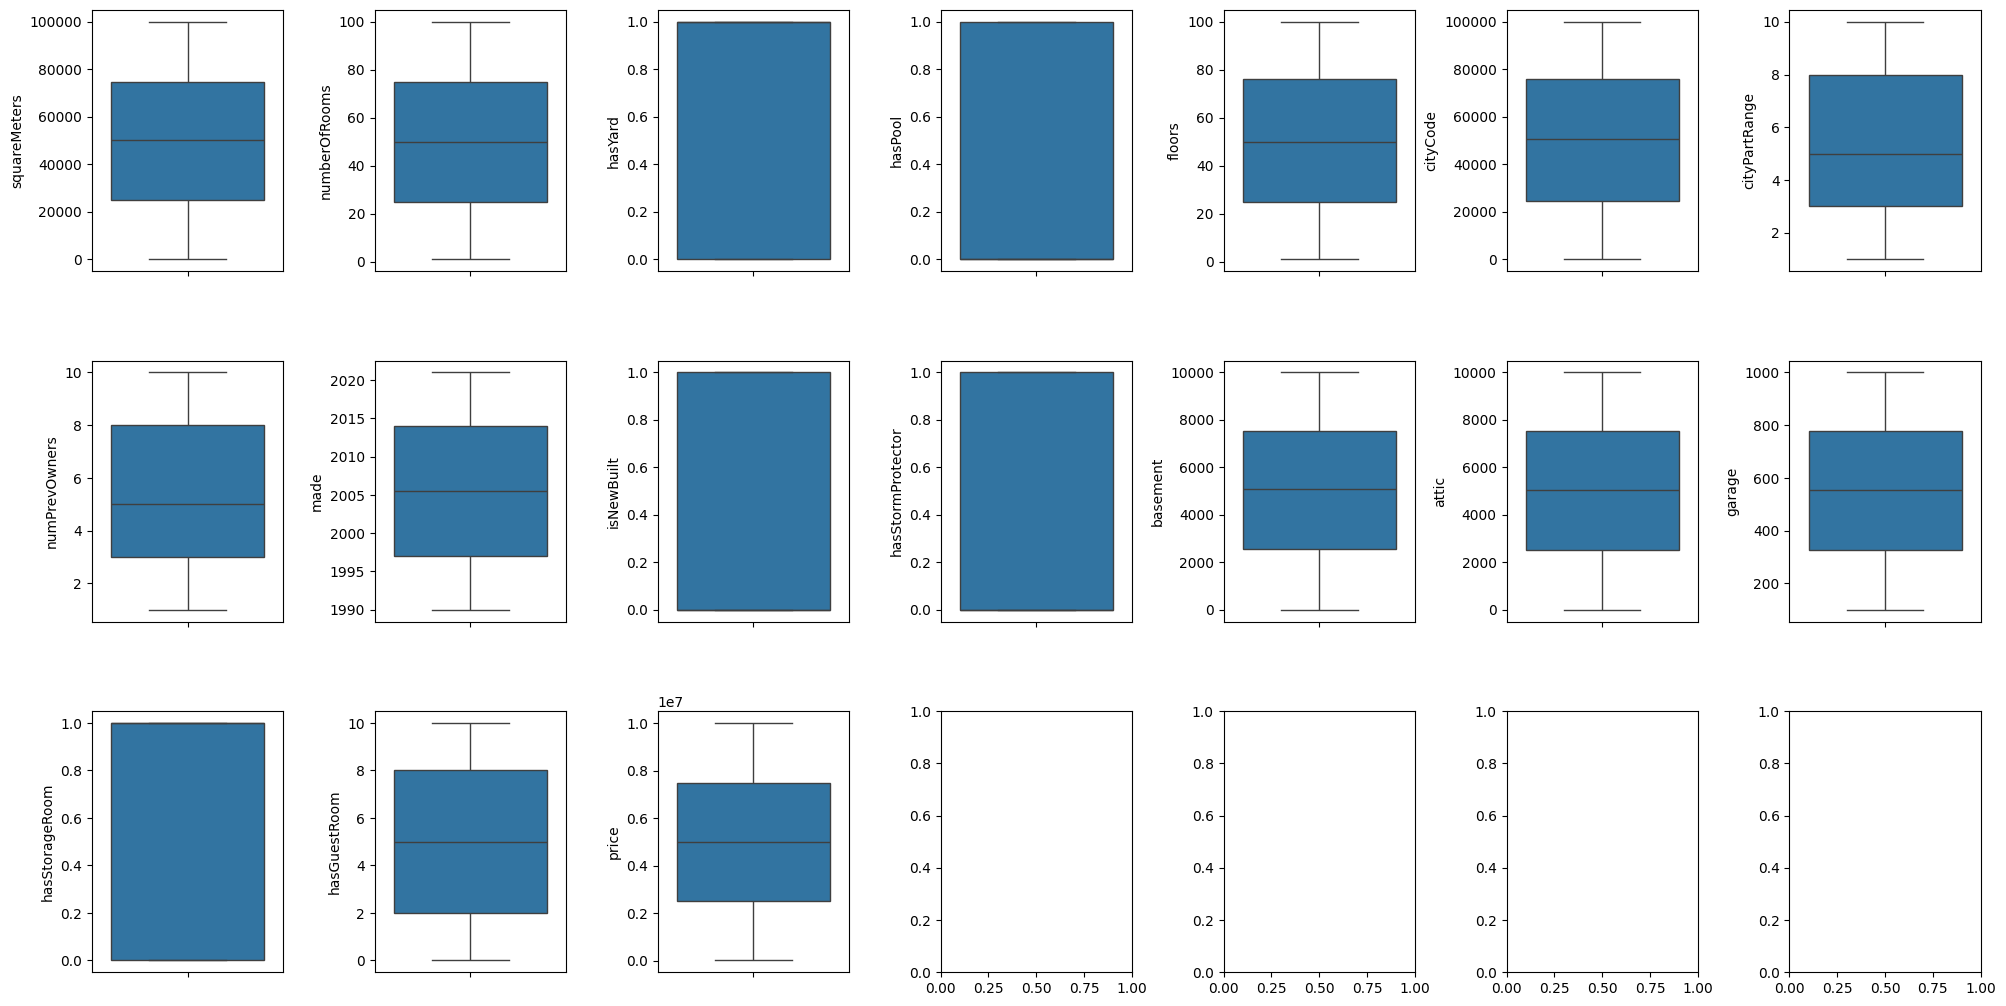

In [8]:
# create box plots
fig, ax = plt.subplots(ncols=7, nrows=3, figsize=(20, 10))
index = 0
ax = ax.flatten()

for col, value in df.items():
    sns.boxplot(y=col, data=df, ax=ax[index])
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

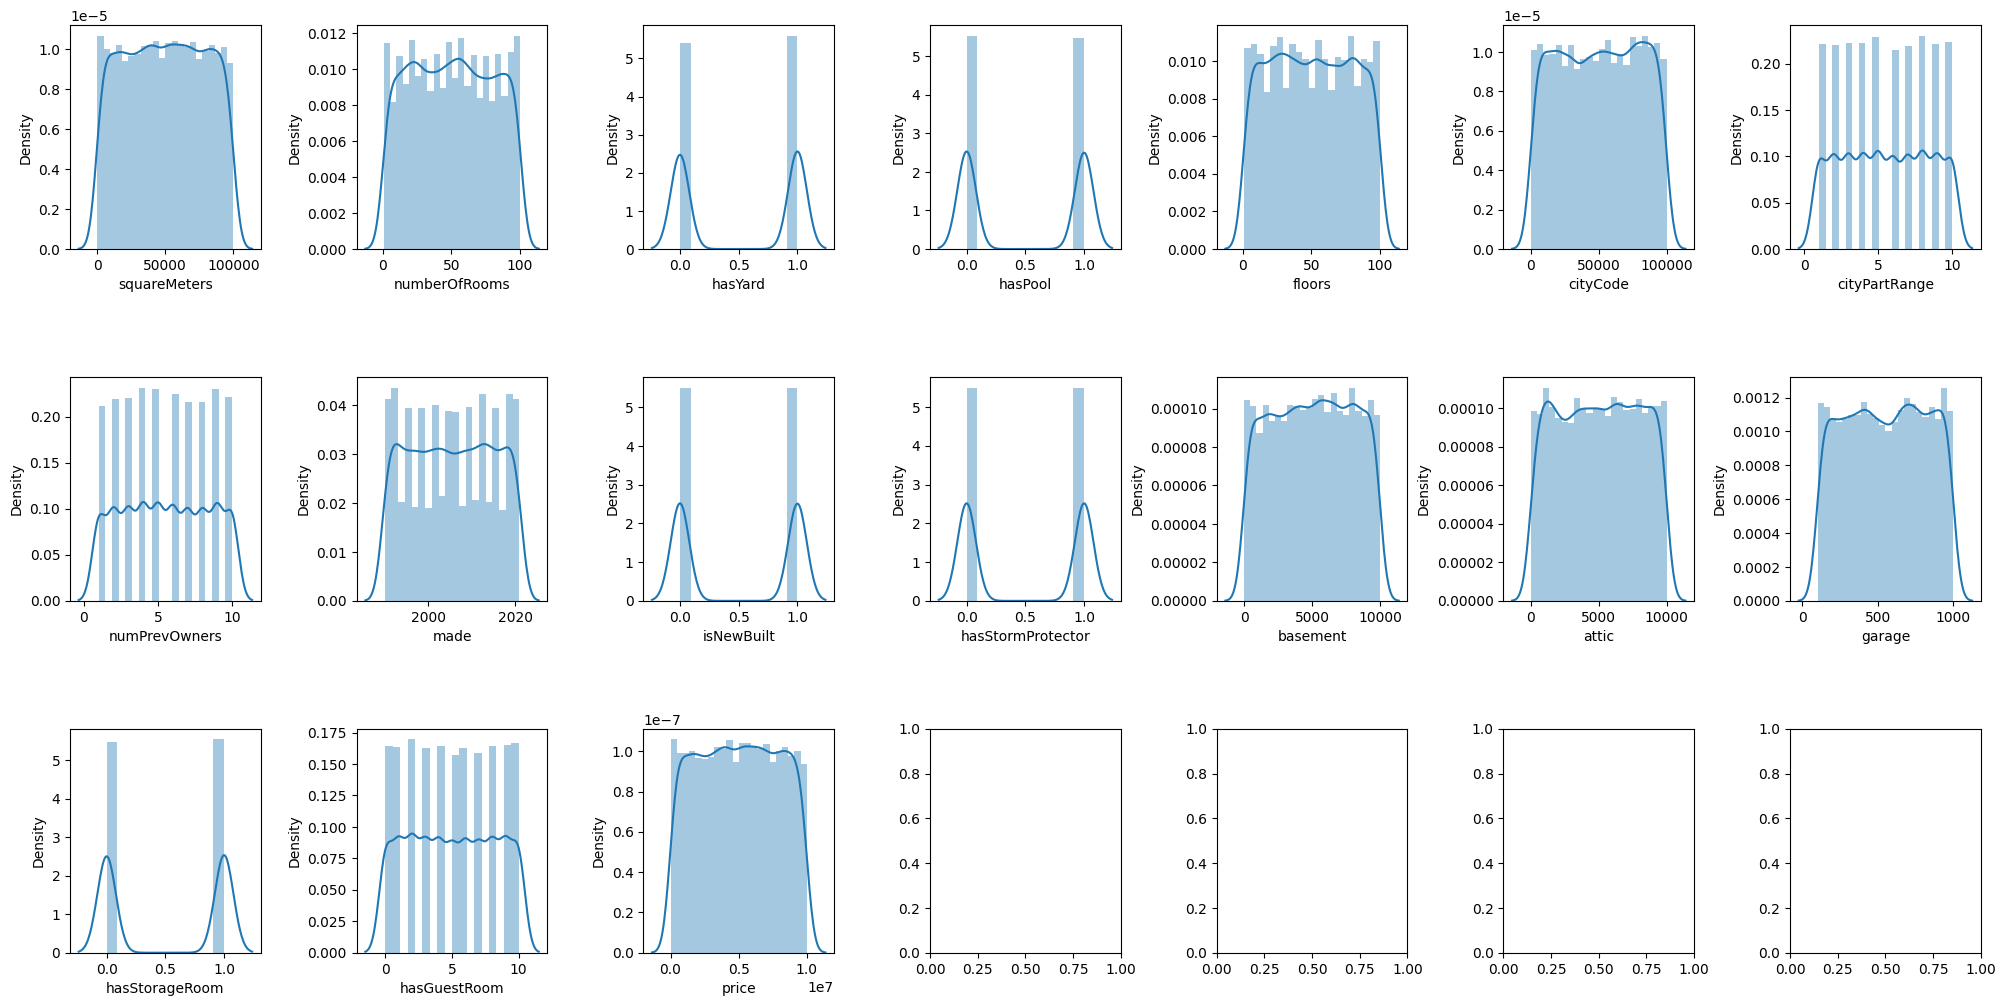

In [10]:
# create dist plot
fig, ax = plt.subplots(ncols=7, nrows=3, figsize=(20, 10))
index = 0
ax = ax.flatten()

for col, value in df.items():
    sns.distplot(value, ax=ax[index])
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

## Correlation Analysis

<Axes: >

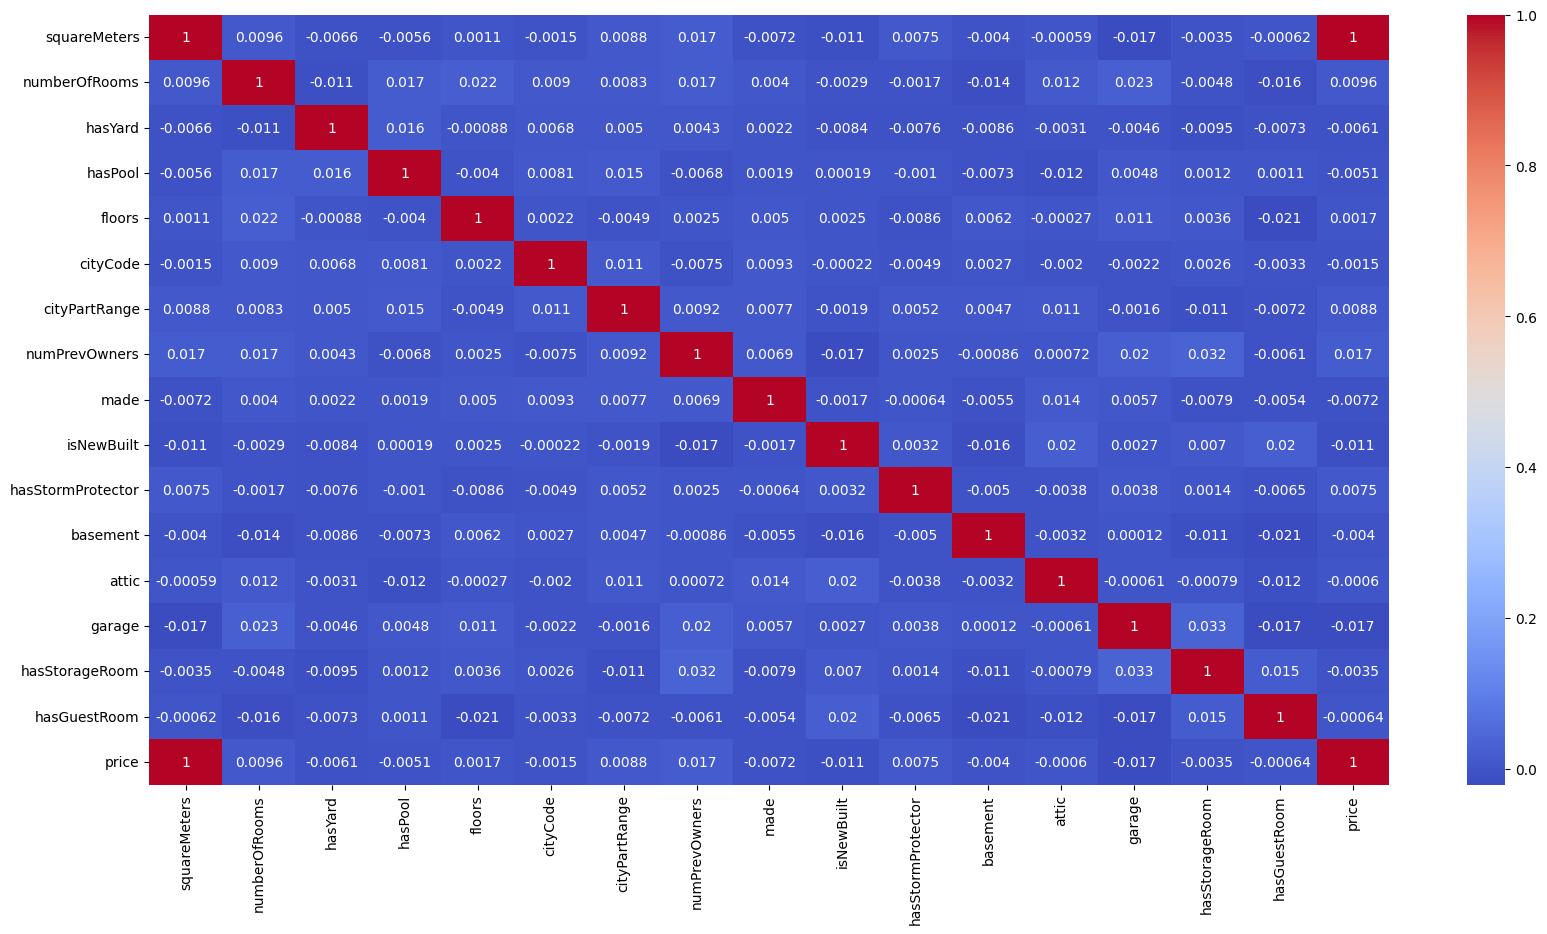

In [11]:
corr = df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')

* We observe a highly positive correlation between **price** and **squareMeters**.
* We will later eliminate this correlation by ignoring any of the variables.
* Surprisingly, some great features such as having **a pool**, **a garage**, **a basement** or **a guestroom** have a little but negative correlation with **price**.


<Axes: xlabel='squareMeters', ylabel='price'>

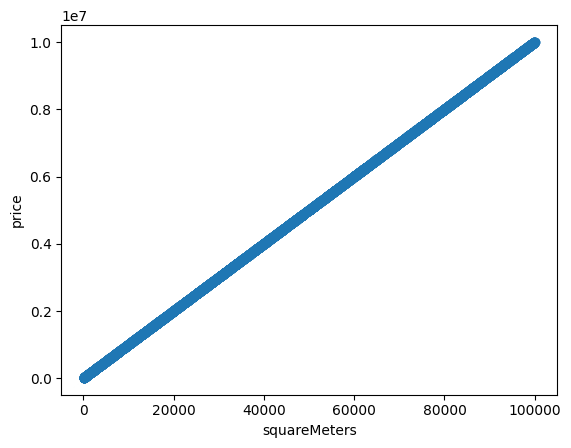

In [12]:
sns.regplot(y=df['price'], x=df['squareMeters'])

* Perfect positive linear correlation

<Axes: xlabel='numberOfRooms', ylabel='price'>

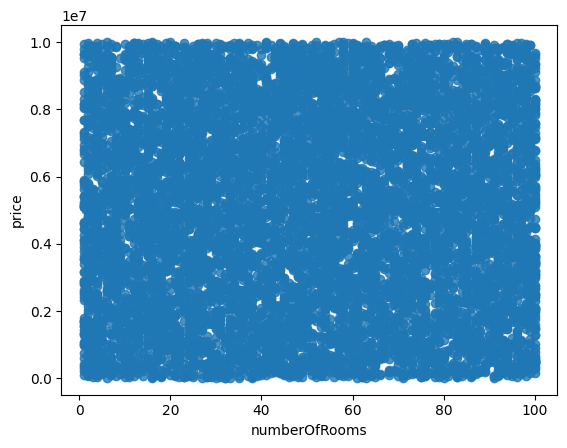

In [13]:
sns.regplot(y=df['price'], x=df['numberOfRooms'])

* On the other hand, it his hard to define the effect of number of rooms on the price, it seems like number of room does not have any effect on price.

## Model Traning

* split the data for training

In [14]:
X = df.drop(columns=['price', 'squareMeters'], axis=1)
y = df['price']

* If you train and test the dataset completely, the results will be inaccurate. Hence, we will use **train_test_split**
* We will add random_state with the attribute 42 to get the same split upon re-running.
* cv_score = we use cross-value score to define the best validation model
* cv=5 because we split the data in 5
* **np.abs** will convert the negative score to positive and **np.mean** will give the average value of 5 scores.

In [15]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
def train(model, X, y):
    # train the model
    x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)
    model.fit(x_train, y_train)

    # predict the training set
    pred = model.predict(x_test)

    # perform cross-validation
    cv_score = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    cv_score = np.abs(np.mean(cv_score))

    print("Model Report")
    print("MSE:",mean_squared_error(y_test, pred))
    print('CV Score:', cv_score)

### Linear Regression

Model Report
MSE: 8684377052627.939
CV Score: 8291786913908.933


<Axes: title={'center': 'Model Coefficients'}>

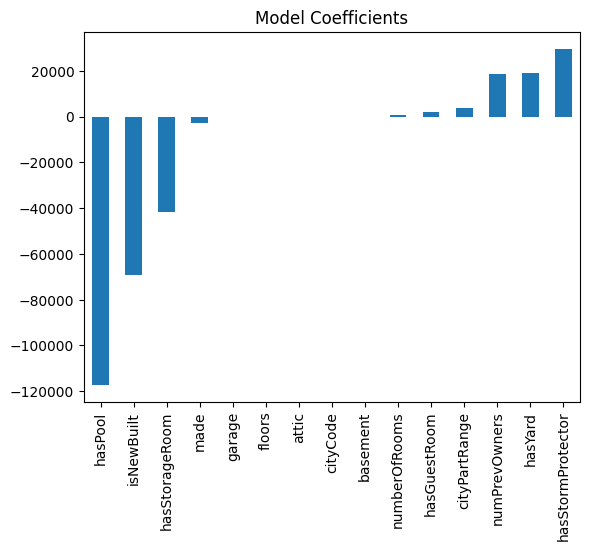

In [17]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
train(model, X, y)
coef = pd.Series(model.coef_, X.columns).sort_values()
coef.plot(kind='bar', title='Model Coefficients')

* **hasPool** shows a high negative coefficient and **hasStormProtector** shows a small positive coefficient.

### Decision Tree

Model Report
MSE: 16239028778166.803
CV Score: 16685555841605.441


<Axes: title={'center': 'Feature Importance'}>

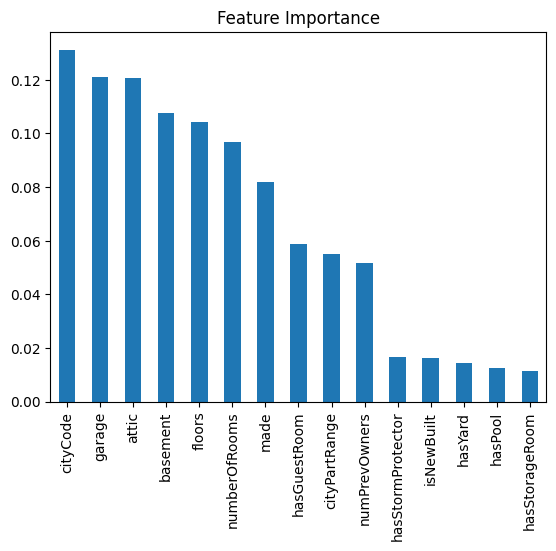

In [18]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
train(model, X, y)
coef = pd.Series(model.feature_importances_, X.columns).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importance')

* All variables shows a positive correlation on price, same goes for the following models.

### Random Forest

Model Report
MSE: 8915059226556.875
CV Score: 8530206293702.084


<Axes: title={'center': 'Feature Importance'}>

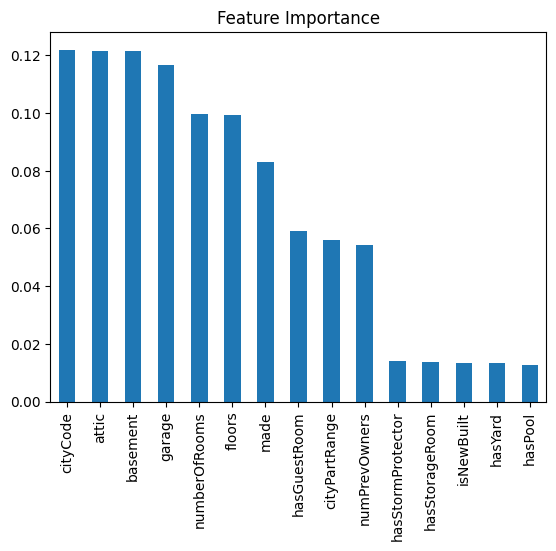

In [19]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
train(model, X, y)
coef = pd.Series(model.feature_importances_, X.columns).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importance')

### Extra Tree

Model Report
MSE: 8978066987521.262
CV Score: 8532682103109.425


<Axes: title={'center': 'Feature Importance'}>

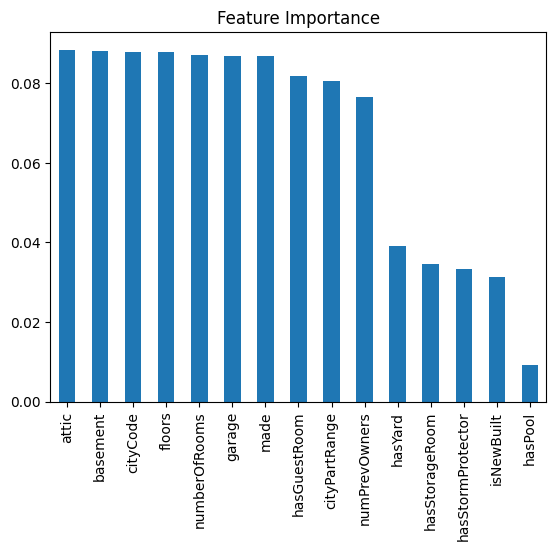

In [20]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
train(model, X, y)
coef = pd.Series(model.feature_importances_, X.columns).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importance')

### XGBoost

Model Report
MSE: 10027988071201.557
CV Score: 9707512211200.209


<Axes: title={'center': 'Feature Importance'}>

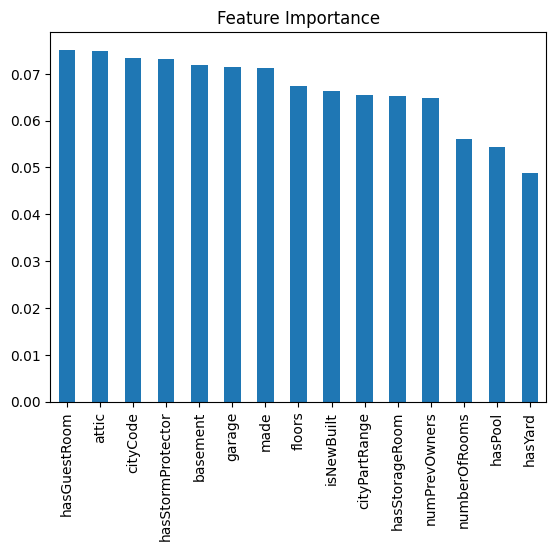

In [21]:
import xgboost as xgb
model = xgb.XGBRegressor()
train(model, X, y)
coef = pd.Series(model.feature_importances_, X.columns).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importance')

## Conclusion

* Every models shows a very high Mean Squared Error estimator and high cross-value which makes none of the models usable. However, the best among the five models remains linear regressor.
* I feel like most the variables have such a low statistical significance that it is difficult to predict the price, we can just summarize the fact that size of the propertu matters more than all other variables put together. Therefore, we could ignore most of the parameters and create a more simplified model with only significant independent variable to reduce the out of our results.